# Classificazione di Testi Spam e NON-Spam

Lo scopo di questo progetto

Tutti i riferimenti ad articoli che sono stati utili per la realizzazione di questo progetto sono disponibili nell'ultima sezione di questo notebook, inclusa la fonte dalla quale è stato ottenuto l'unico dataset utilizzato per questo progetto. Il Dataset in questione consta di circa 5500 righe, in formato csv, e in ogni riga troviamo una stringa di testo, la quale rappresenta il messaggio da valutare, e un'etichetta in formato testuale autoesplicativa, con due valori ammessi (spam, ham).

Importiamo le librerie:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join, dirname
from keras.preprocessing.text import Tokenizer
from joblib import dump
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Andiamo a leggere il dataset precaricato sfruttando le funzionalità della libreria *pandas*:

In [2]:
df = pd.read_csv("spam_messages.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
df.describe().transpose()

,count,unique,top,freq
Category,5572,2,ham,4825
Message,5572,5157,"Sorry, I'll call later",30


## Distribuzione delle etichette del Dataset

<AxesSubplot: xlabel='Category', ylabel='count'>

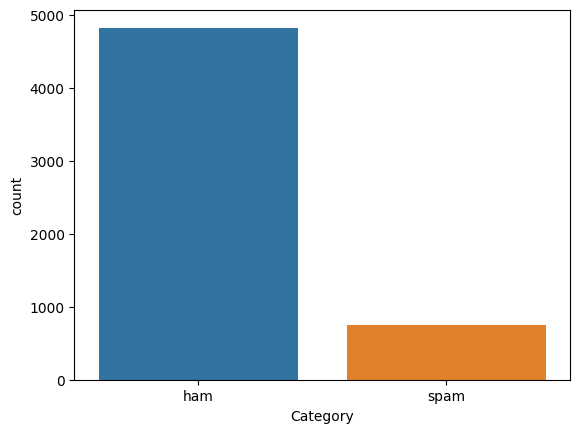

In [4]:
sns.countplot(x=df["Category"])

Come si può osservare nel grafico a barre riportato di sopra, la distribuzione delle etichette è particolarmente sbilanciata, questo potrebbe portare a problematiche nelle fasi successive all'apprendimento.

Prima di poter lavorare adeguatamente con i nostri dati, procediamo con la separazione delle due variabili del nostro Dataset:

In [5]:
messages = df['Message']
labels = df['Category']

Definiamo una serie di variabili e costanti che ci saranno utili nelle fasi successive:

In [6]:
MAX_TEXT_LEN = messages.map(lambda message: len(message)).max()
print(f"The max count of characters is {MAX_TEXT_LEN}")

The max count of characters is 910


In [7]:
MODEL_PATH = "training_1/model"
model_dir = dirname(MODEL_PATH)
tokenizer_path = join(model_dir, "tokenizer.joblib")

### Tokenizzazione

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(messages)
dump(tokenizer, tokenizer_path)

['training_1\\tokenizer.joblib']

In [9]:
sequences = tokenizer.texts_to_sequences(messages)

## Distribuzione dei conteggi delle parole

Lo svolgimento di questa fase si rende necessario nel momento in cui, nelle fasi successive all'addestramento, si voglia trovare una correlazione tra errori commessi dal modello e la lunghezza dei messaggi.

The max number of words is 189
9004


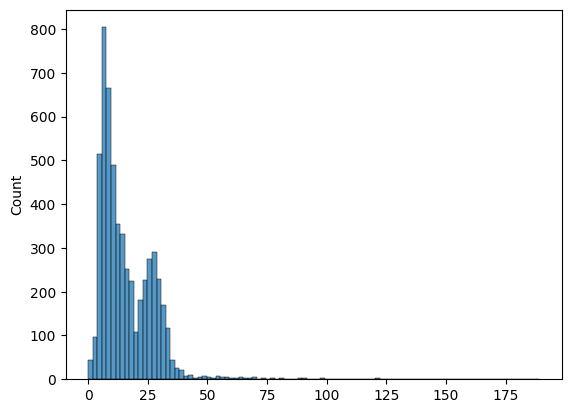

In [10]:
sequences_len = []
for sequence in sequences:
    seq_len = len(sequence)
    sequences_len.append(seq_len)
sequences_len = np.array(sequences_len)
NUM_WORDS = sequences_len.max()
VOCABULARY_SIZE = len(tokenizer.word_index)
print(f"The max number of words is {NUM_WORDS}")
sns.histplot(sequences_len)
print(VOCABULARY_SIZE)

## Addestramento del modello

In [11]:
X = pad_sequences(sequences, maxlen=NUM_WORDS)
y = np.where(labels == "ham", 1, 0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(f'Training sample size: {len(X_train)}')
print(f'Test sample size: {len(X_test)}')

Training sample size: 4457
Test sample size: 1115


In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(VOCABULARY_SIZE, 128, input_length=NUM_WORDS),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(metrics=tf.metrics.BinaryAccuracy(threshold=0.0), loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 189, 128)          1152512   
                                                                 
 dropout (Dropout)           (None, 189, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 189, 128)          0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [14]:
history = model.fit(X_train, y_train, batch_size=25, epochs=15, validation_split=0.2, verbose=1)

Epoch 1/15
143/143 [==============================] - 5s 8ms/step - loss: 0.4446 - binary_accuracy: 0.8679 - val_loss: 0.3892 - val_binary_accuracy: 0.8576
Epoch 2/15
143/143 [==============================] - 1s 6ms/step - loss: 0.3657 - binary_accuracy: 0.8679 - val_loss: 0.3778 - val_binary_accuracy: 0.8576
Epoch 3/15
143/143 [==============================] - 1s 6ms/step - loss: 0.3506 - binary_accuracy: 0.8679 - val_loss: 0.3626 - val_binary_accuracy: 0.8576
Epoch 4/15
143/143 [==============================] - 1s 6ms/step - loss: 0.3313 - binary_accuracy: 0.8679 - val_loss: 0.3411 - val_binary_accuracy: 0.8576
Epoch 5/15
143/143 [==============================] - 1s 6ms/step - loss: 0.3036 - binary_accuracy: 0.8679 - val_loss: 0.3072 - val_binary_accuracy: 0.8576
Epoch 6/15
143/143 [==============================] - 1s 6ms/step - loss: 0.2660 - binary_accuracy: 0.8679 - val_loss: 0.2671 - val_binary_accuracy: 0.8576
Epoch 7/15
143/143 [==============================] - 1s 6ms/ste

In [15]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: training_1/model\assets


<AxesSubplot: >

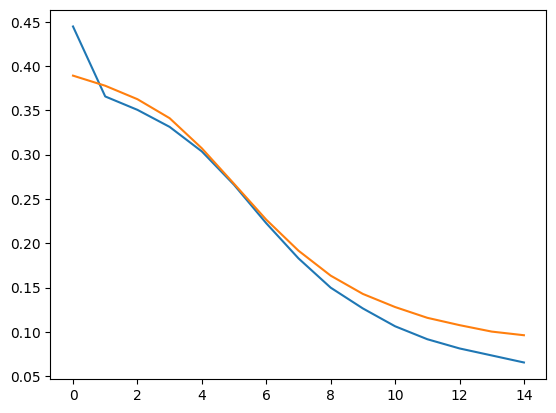

In [16]:
sns.lineplot(history.history["loss"])
sns.lineplot(history.history["val_loss"])

# Comprensione dei risultati

Il nostro modello è stato addesstrato, con dei risulati apparentemente soddisfacenti. Ciò però non significa necessariamente che il suo comportamento sia quello da noi desiderato.

In [17]:
y_predict = model.predict(X_test).flatten()

35/35 [==============================] - 0s 1ms/step


In [18]:
y_predict_labels = np.where(y_predict > 0.5, 1, 0)

### Matrice di confusione

Si rende molto utile in questa fase di comprensione dei dati, l'utilizzo di una **matrice di confusione** per una rappresentazione dei *risultati ottenuti dal modello*. Calcoliamo quindi per ogni etichetta quante sono le entry per le quali le etichette sono state correttamente predette dal modello nel *dataset di test* e quali invece sono state sbagliate.

In [19]:
spam = y_predict_labels[y_predict_labels == 1]
differences = np.where(y_predict_labels == y_test, 1, 0) # Check differences
true_ham = np.where((y_test == 1) & (y_predict_labels == 1), 1, 0).sum()
false_ham = np.where((y_test == 0) & (y_predict_labels == 1), 1, 0).sum()
total_ham = true_ham + false_ham
true_spam = np.where((y_test == 1) & (y_predict_labels == 0), 1, 0).sum()
false_spam = np.where((y_test == 0) & (y_predict_labels == 0), 1, 0).sum()
total_spam = true_spam + false_spam

<AxesSubplot: >

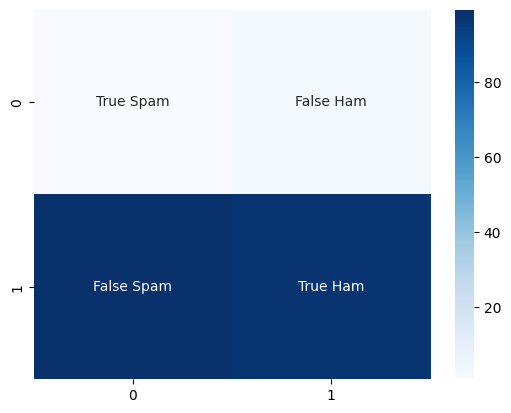

In [20]:
sns.heatmap([[true_spam/total_spam*100, false_ham/total_ham*100], [false_spam/total_spam*100, true_ham/total_ham*100]], annot=np.asarray(["True Spam", "False Ham", "False Spam", "True Ham"]).reshape(2,2), fmt="", cmap="Blues")

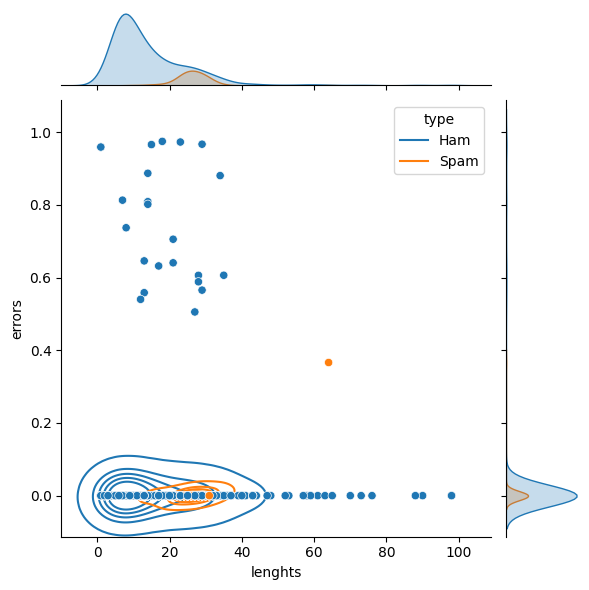

In [21]:
y_prediction_errors = np.where(y_predict_labels != y_test, y_predict, 0)
X_test_lenghts = [len([t for t in X if t != 0]) for X in X_test]
errors_df = pd.DataFrame(data = { "errors": y_prediction_errors, "lenghts": X_test_lenghts, "type": np.where(y_predict_labels == 1, "Ham", "Spam") })
sns.jointplot(x="lenghts", y="errors", hue="type", data=errors_df)\
.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

Seppure il modello abbia totalizzato un'accuratezza molto alta, andando a visualizzare in dettaglio i risultati, si nota che il modello è più bravo a riconoscere casi di Non-Spam piuttosto che casi di Spam. Questo fattore potrebbe assolutamente essere riconducibile allo sbilanciamento delle etichette.

## Conclusioni

Nonostante l'elevata accuratezza del modello nella classificazione di dati provenienti dal Dataset utilizzato per l'apprendimento, il suo comportamento presenta molti dubbi nel caso in cui lo si utilizzi per predirre l'etichetta di nuove stringe (magari scritte a mano). Questo comportamento potrebbe essere una delle conseguenze della poca numerosità dei dati.

## Fonti

Di seguito sono riportati articoli e fonti da cui sono state raccolte tutte le info necessarie per la realizzazione di questo progetto.

[Basic text classification | TensorFlow Core](https://www.tensorflow.org/tutorials/keras/text_classification?hl=it)

[Save and load models | TensorFlow Core](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=it)

[Spam Text Message Classification](https://www.kaggle.com/datasets/team-ai/spam-text-message-classification)

[Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)